# MOS score prediction from wav2vec2 embeddings

* calculate wav2vec2 embeddings for test and train datasets
* create MOSDataset, containing wav2vec2 embeddings and subjective MOS scores
* define a simple neural network to predict MOS scores from wav2vec2 embeddings
* train the neural network and save the model
* evaluate the model
* repeat the process for different wav2vec2 models? other embeddings? use embeddings from different layers? need another 8 months to finish this notebook

In [1]:
import os
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# wav2vec
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model, Wav2Vec2Config
import librosa

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


/home/aleph/tesis/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# wav2vec2 embeddings extraction

In [2]:
def wav2vec_embeddings(path_to_csv, model_name, output_dir):
    """Extracts embeddings from audio files given a specific Wav2Vec2 model.
    Extracts all layers and stacks them together into a tensor. Then saves that tensor as a numpy array.
    Expects csv file with a column named "stimuli" containing paths to audio files."""

    os.makedirs(output_dir, exist_ok=True)

    config = Wav2Vec2Config.from_pretrained(model_name, output_hidden_states=True)
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
    model = Wav2Vec2Model(config)
    
    #load data
    metadata_df = pd.read_csv(path_to_csv)

    # iterate over each path in "stimuli" column
    for _, row in tqdm(metadata_df.iterrows()):
        audio_file = row['stimuli']
        input_audio, sample_rate = librosa.load(audio_file, sr=16000)
        inputs = feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)
        
        with torch.no_grad():
            outputs= model(**inputs)
        
        all_layer_embeddings = outputs.hidden_states

        # Concatenate hidden states from all layers and take the mean across the sequence
        # Skip the first layer --> output of the CNN layers with an added positional embedding
        embeddings = torch.cat(all_layer_embeddings[, dim=0)
        embeddings = embeddings.mean(dim=1)

        # Save embeddings as numpy array
        embeddings = embeddings.squeeze().detach().numpy()
        file_name = os.path.basename(audio_file).split('.')[0]

        np.save(os.path.join(output_dir, f"{file_name}.npy"), embeddings)

In [9]:
# extract embeddings for dev set
path_to_dev_csv = '/home/aleph/tesis/classifier/dev.csv'
path_to_dev_embeddings = '/home/aleph/tesis/classifier/embeddings/dev'
# wav2vec_embeddings(path_to_dev_csv, path_to_dev_embeddings)

# extract embeddings for test set
path_to_test_csv = '/home/aleph/tesis/classifier/test.csv'
path_to_test_embeddings = '/home/aleph/tesis/classifier/embeddings/test'
# wav2vec_embeddings(path_to_test_csv, path_to_test_embeddings)

# extract embeddings for train set
path_to_train_csv = '/home/aleph/tesis/classifier/train.csv'
path_to_train_embeddings = '/home/aleph/tesis/classifier/embeddings/train'
# wav2vec_embeddings(path_to_train_csv, path_to_train_embeddings)

OSError: facebook/wav2vec2-base-960h does not appear to have a file named config.json. Checkout 'https://huggingface.co/facebook/wav2vec2-base-960h/tree/main' for available files.

## attempt to plot some sort of distribution of the embeddings

In [12]:
# let's explore the embeddings to see distributions of data
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
from numpy import float32

# get the embeddings read from the csv
train_embeddings = pd.read_csv(path_to_save_train_embeddings)
test_embeddings = pd.read_csv(path_to_save_test_embeddings)

# get the embeddings
train_embeddings = train_embeddings['embeddings']
test_embeddings = test_embeddings['embeddings']

# convert the strings to lists
train_embeddings = train_embeddings.apply(lambda x: eval(x))
test_embeddings = test_embeddings.apply(lambda x: eval(x))

# convert the lists to numpy arrays
train_embeddings = np.array(train_embeddings.tolist())
test_embeddings = np.array(test_embeddings.tolist())

# get the shape of the embeddings
print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")




Train embeddings shape: (3473, 1, 768)
Test embeddings shape: (863, 1, 768)


In [38]:
import umap.umap_ as umap

#Create a numpy array with the features and project them to 2D using UMAP:
X = np.stack(train_embeddings.squeeze())
print('Projecting to 2D with UMAP')
projector = umap.UMAP()
projected = projector.fit_transform(X)
metadata_df = pd.DataFrame()
metadata_df['X'] = projected[:,0]
metadata_df['Y'] = projected[:,1]

Projecting to 2D with UMAP


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


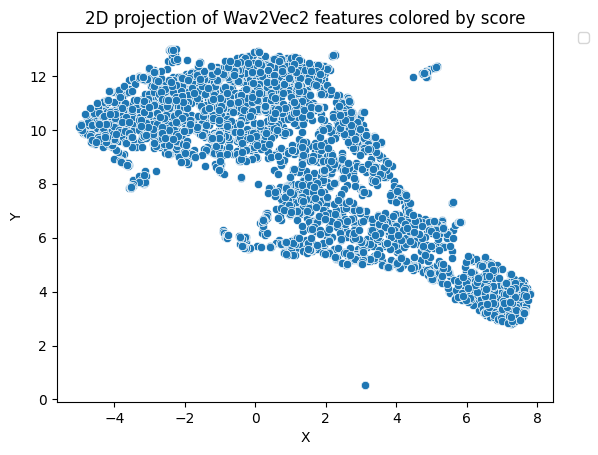

In [40]:
plt.title('2D projection of Wav2Vec2 features colored by score')
sns.scatterplot(data=metadata_df,x='X',y='Y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Projecting to 2D with UMAP


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


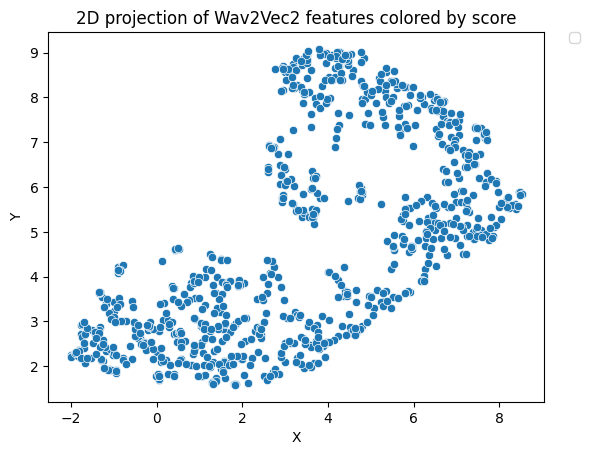

In [41]:
import umap.umap_ as umap

#Create a numpy array with the features and project them to 2D using UMAP:
X = np.stack(test_embeddings.squeeze())
print('Projecting to 2D with UMAP')
projector = umap.UMAP()
projected = projector.fit_transform(X)
metadata_df = pd.DataFrame()
metadata_df['X'] = projected[:,0]
metadata_df['Y'] = projected[:,1]

plt.title('2D projection of Wav2Vec2 features colored by score')
sns.scatterplot(data=metadata_df,x='X',y='Y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# MOSDataset
* Convert the embeddings from string representations into proper tensors.
* Separate the data into features (embeddings) and targets (MOS scores).

In [13]:
# Custom dataset to read embeddings and MOS scores from a CSV
from numpy import array
from numpy import float32

class MOSDataset(Dataset):
    def __init__(self, csv_file, split):
        # Load the CSV file
        self.data = pd.read_csv(csv_file)
        self.split = "shuffled_960"  # Store the split (train, val, test)

        
    def __len__(self):
        return len(self.data)  # Total number of samples in the dataset
    
    def __getitem__(self, idx):
        # Get the embeddings and MOS scores for the given index
        file_name = os.path.basename(self.data.iloc[idx]['stimuli'])
        file_folder = os.path.basename(os.path.dirname(self.data.iloc[idx]['stimuli']))

        embeddings_path = f"/home/aleph/tesis/classifier/embeddings/{self.split}/{file_folder}/{file_name.split('.')[0]}.npy"
        # print(embeddings_path)
        # Check if the embeddings file exists
        if not os.path.isfile(embeddings_path):
            raise FileNotFoundError(f"Embeddings file not found at {embeddings_path}")

        embeddings = np.load(embeddings_path)

        mos_score = self.data.iloc[idx]['mos']

        # Convert the numpy array of embeddings to a tensor
        embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)  # Convert to PyTorch tensor

        # drop first layer
        # embeddings_tensor = embeddings_tensor[1:]
                
        # MOS score should be a single value
        mos_tensor = torch.tensor([mos_score], dtype=torch.float32)  # Convert to tensor
        
        return embeddings_tensor, mos_tensor

# Create the training DataLoader
train_csv_path = "/home/aleph/tesis/classifier/train_shuffled.csv"
train_dataset = MOSDataset(train_csv_path, split='train')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)  # DataLoader with batching and shuffling

# Create the validation DataLoader
val_csv_path = "/home/aleph/tesis/classifier/val_shuffled.csv"
val_dataset = MOSDataset(val_csv_path, split='val')
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Create the testing DataLoader
test_csv_path = "/home/aleph/tesis/classifier/test_shuffled.csv"
test_dataset = MOSDataset(test_csv_path, split='test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2) 


In [14]:
# Test getting an item
try:
    embeddings, mos = val_dataset[300]  # Test the first item
    print("Embeddings shape:", embeddings.shape)  # Expected shape
    print("MOS score:", mos.item())  # Expected MOS score
except Exception as e:
    print("Error getting item:", e)

Embeddings shape: torch.Size([13, 768])
MOS score: 2.5


In [15]:
# print path to an example file
print(val_dataset.data.iloc[300]['stimuli'])

/home/aleph/tesis/frontend/public/assets/stimuli_norm/C/C7/conchita_42.wav


In [16]:
#print length of the datasets
print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

Train dataset length: 3139
Validation dataset length: 393
Test dataset length: 392


# Neural network

In [17]:
class WeightedAverage(torch.nn.Module):
    def __init__(self, num_layers=12):
        super().__init__()
        self.weights = torch.nn.Parameter(data=torch.ones((num_layers,)))
       
    def forward(self, x):
        w = torch.nn.functional.softmax(self.weights, dim=0)
        x_weighted = x*w[None,:,None]
        return torch.sum(x_weighted, dim=1)

class DenseMOS(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_prob, num_layers):
        super(DenseMOS, self).__init__()

        # add a weighted average layer
        self.weighted_average = WeightedAverage(num_layers)
        
        # First dense layer with 128 neurons, ReLU activation, and dropout
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # Linear layer for dense transformation
            nn.ReLU(),  # ReLU activation
            nn.Dropout(dropout_prob),  # Dropout with 0.2
        )

        # Second dense layer, same design
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
        )

        # Final dense layer for MOS score prediction
        self.output_layer = nn.Linear(hidden_dim, 1)  # Linear layer to predict MOS

    def forward(self, x):
        # Apply the weighted average to combine 12 layers into 1
        x = self.weighted_average(x)  # Apply WeightedAverage

        # Pass the input through the first dense layer
        x = self.layer1(x)

        # Pass through the second dense layer
        x = self.layer2(x)

        # Pass through the final dense layer to get the MOS score
        x = self.output_layer(x)  # Output layer
        
        # min max normalization to 1-5
        x = 1 + (x - x.min()) * 4 / (x.max() - x.min())
        

        return x


# Define the model parameters
input_dim = 768  # Single 768-dimensional input
hidden_dim = 128  # Hidden dimension for dense layers
dropout_prob = 0.6  # Dropout probability
num_layers = 13  # Number of layers in the Wav2Vec2 model

# Training

In [21]:
# Instantiate the DenseMOS model
dense_mos = DenseMOS(input_dim, hidden_dim, dropout_prob, num_layers)
dense_mos.to(device)  # Move the model to the device

DenseMOS(
  (weighted_average): WeightedAverage()
  (layer1): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
  )
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

## Define a Loss Function and Optimizer


In [22]:
# define loss and optimizer
loss_fn = nn.MSELoss()  # Mean squared error loss
# propose a different possible loss function
# loss_fn = nn.SmoothL1Loss()  # Huber loss

# Assuming you are using an optimizer like Adam
# optimizer = torch.optim.Adam(dense_mos.parameters(), lr=1e-4, weight_decay=1e-5)  # Add L2 regularization
# optimizer = torch.optim.Adam(dense_mos.parameters(), lr=1e-4)

base_params = [p for name, p in dense_mos.named_parameters() if "weights" not in name]
weight_params = [dense_mos.weighted_average.weights]
optimizer = torch.optim.Adam([
    {'params': base_params},
    {'params': weight_params, 'lr': 1e-3}  # Higher learning rate for weights
], lr=1e-4)

## Training Loop

In [23]:
# Number of epochs and batch size
num_epochs = 1000 # Number of training epochs
batch_size = 32  # Batch size for training

# DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Ensure batch size and shuffle
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # No shuffle for validation

# Track training and validation loss
train_losses = []
val_losses = []

# For early stopping
best_val_loss = float('inf')  # To track the best validation loss
patience = 25  # Patience for early stopping
no_improvement_count = 0  # Counter for epochs without improvement

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Decay LR every 10 epochs

for epoch in range(num_epochs):
    # Training phase with progress bar
    dense_mos.train()  # Set model to training mode
    train_loss = 0.0  # Initialize the training loss
    
    # Use tqdm for progress tracking
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
        for inputs, targets in train_loader:
            inputs = inputs.to(device)  # Move inputs to the GPU
            targets = targets.to(device)  # Move targets to the GPU

            optimizer.zero_grad()  # Zero out the gradients
            
            outputs = dense_mos(inputs)  # Forward pass
            loss = loss_fn(outputs, targets)  # Compute the loss
            loss.backward()  # Backpropagation
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(dense_mos.parameters(), 1.0)  # Adjust value if needed
            
            optimizer.step()  # Update the weights
            
            train_loss += loss.item()  # Accumulate the loss
            
            pbar.update(1)  # Update the progress bar

    train_loss /= len(train_loader)  # Average loss over all batches
    train_losses.append(train_loss)  # Save the training loss

    # Validation phase
    dense_mos.eval()  # Set model to evaluation mode
    val_loss = 0.0  # Initialize the validation loss

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)  # Move inputs to the GPU
            targets = targets.to(device)  # Move targets to the GPU

            outputs = dense_mos(inputs)  # Forward pass
            loss = loss_fn(outputs, targets)  # Calculate loss
            val_loss += loss.item()  # Accumulate the validation loss

    val_loss /= len(val_loader)  # Average validation loss over all batches
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    # scheduler.step() # Step the scheduler

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(dense_mos.state_dict(), "best_model_960.pth")  # Save the best model
        no_improvement_count = 0  # Reset counter
    else:
        no_improvement_count += 1  # Increment counter if no improvement

    # Early stopping check
    if no_improvement_count >= patience:
        print(f"Stopping early after {epoch + 1} epochs due to no improvement in validation loss.")
        break

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the model (optional)
        torch.save(dense_mos.state_dict(), "best_model_960.pth")

    # Save the model at the end of training
    torch.save(dense_mos.state_dict(), "final_model_960.pth")

    # print the softmax of the weights of the weighted average layer
    # print(dense_mos.weighted_average.weights)
    # print(torch.nn.functional.softmax(dense_mos.weighted_average.weights, dim=0))
# save train and val losses to csv
losses = pd.DataFrame({'train_loss': train_losses, 'val_loss': val_losses})
losses.to_csv('losses_960.csv', index=False)

Epoch 1/1000: 100%|██████████| 99/99 [00:01<00:00, 83.22it/s]


Epoch 1/1000, Training Loss: 2.7952, Validation Loss: 3.1291


Epoch 2/1000: 100%|██████████| 99/99 [00:01<00:00, 86.61it/s]


Epoch 2/1000, Training Loss: 2.4382, Validation Loss: 2.6428


Epoch 3/1000: 100%|██████████| 99/99 [00:01<00:00, 84.31it/s]


Epoch 3/1000, Training Loss: 2.2790, Validation Loss: 2.1378


Epoch 4/1000: 100%|██████████| 99/99 [00:01<00:00, 84.56it/s]


Epoch 4/1000, Training Loss: 2.0826, Validation Loss: 1.7697


Epoch 5/1000: 100%|██████████| 99/99 [00:01<00:00, 83.79it/s]


Epoch 5/1000, Training Loss: 1.8815, Validation Loss: 1.7054


Epoch 6/1000: 100%|██████████| 99/99 [00:01<00:00, 84.16it/s]


Epoch 6/1000, Training Loss: 1.8900, Validation Loss: 1.6547


Epoch 7/1000: 100%|██████████| 99/99 [00:01<00:00, 84.75it/s]


Epoch 7/1000, Training Loss: 1.7597, Validation Loss: 1.7696


Epoch 8/1000: 100%|██████████| 99/99 [00:01<00:00, 83.54it/s]


Epoch 8/1000, Training Loss: 1.7912, Validation Loss: 1.7500


Epoch 9/1000: 100%|██████████| 99/99 [00:01<00:00, 81.77it/s]


Epoch 9/1000, Training Loss: 1.7595, Validation Loss: 1.5670


Epoch 10/1000: 100%|██████████| 99/99 [00:01<00:00, 84.35it/s]


Epoch 10/1000, Training Loss: 1.7615, Validation Loss: 1.5701


Epoch 11/1000: 100%|██████████| 99/99 [00:01<00:00, 83.89it/s]


Epoch 11/1000, Training Loss: 1.7016, Validation Loss: 1.5675


Epoch 12/1000: 100%|██████████| 99/99 [00:01<00:00, 83.87it/s]


Epoch 12/1000, Training Loss: 1.6220, Validation Loss: 1.6503


Epoch 13/1000: 100%|██████████| 99/99 [00:01<00:00, 85.02it/s]


Epoch 13/1000, Training Loss: 1.6662, Validation Loss: 1.6080


Epoch 14/1000: 100%|██████████| 99/99 [00:01<00:00, 85.37it/s]


Epoch 14/1000, Training Loss: 1.6451, Validation Loss: 1.5649


Epoch 15/1000: 100%|██████████| 99/99 [00:01<00:00, 81.64it/s]


Epoch 15/1000, Training Loss: 1.6213, Validation Loss: 1.5411


Epoch 16/1000: 100%|██████████| 99/99 [00:01<00:00, 80.48it/s]


Epoch 16/1000, Training Loss: 1.5267, Validation Loss: 1.5142


Epoch 17/1000: 100%|██████████| 99/99 [00:01<00:00, 84.56it/s]


Epoch 17/1000, Training Loss: 1.5610, Validation Loss: 1.5490


Epoch 18/1000: 100%|██████████| 99/99 [00:01<00:00, 82.94it/s]


Epoch 18/1000, Training Loss: 1.5763, Validation Loss: 1.5648


Epoch 19/1000: 100%|██████████| 99/99 [00:01<00:00, 76.44it/s]


Epoch 19/1000, Training Loss: 1.5494, Validation Loss: 1.5081


Epoch 20/1000: 100%|██████████| 99/99 [00:01<00:00, 70.68it/s]


Epoch 20/1000, Training Loss: 1.5180, Validation Loss: 1.4920


Epoch 21/1000: 100%|██████████| 99/99 [00:01<00:00, 83.78it/s]


Epoch 21/1000, Training Loss: 1.5080, Validation Loss: 1.4627


Epoch 22/1000: 100%|██████████| 99/99 [00:01<00:00, 78.97it/s]


Epoch 22/1000, Training Loss: 1.5001, Validation Loss: 1.4641


Epoch 23/1000: 100%|██████████| 99/99 [00:01<00:00, 86.75it/s]


Epoch 23/1000, Training Loss: 1.4852, Validation Loss: 1.3667


Epoch 24/1000: 100%|██████████| 99/99 [00:01<00:00, 86.42it/s]


Epoch 24/1000, Training Loss: 1.5541, Validation Loss: 1.4222


Epoch 25/1000: 100%|██████████| 99/99 [00:01<00:00, 86.37it/s]


Epoch 25/1000, Training Loss: 1.5426, Validation Loss: 1.4476


Epoch 26/1000: 100%|██████████| 99/99 [00:01<00:00, 83.58it/s]


Epoch 26/1000, Training Loss: 1.4641, Validation Loss: 1.4611


Epoch 27/1000: 100%|██████████| 99/99 [00:01<00:00, 85.13it/s]


Epoch 27/1000, Training Loss: 1.4365, Validation Loss: 1.3810


Epoch 28/1000: 100%|██████████| 99/99 [00:01<00:00, 80.61it/s]


Epoch 28/1000, Training Loss: 1.4075, Validation Loss: 1.4831


Epoch 29/1000: 100%|██████████| 99/99 [00:01<00:00, 81.95it/s]


Epoch 29/1000, Training Loss: 1.4702, Validation Loss: 1.2905


Epoch 30/1000: 100%|██████████| 99/99 [00:01<00:00, 85.36it/s]


Epoch 30/1000, Training Loss: 1.4813, Validation Loss: 1.3407


Epoch 31/1000: 100%|██████████| 99/99 [00:01<00:00, 85.24it/s]


Epoch 31/1000, Training Loss: 1.4063, Validation Loss: 1.3226


Epoch 32/1000: 100%|██████████| 99/99 [00:01<00:00, 86.93it/s]


Epoch 32/1000, Training Loss: 1.4313, Validation Loss: 1.2801


Epoch 33/1000: 100%|██████████| 99/99 [00:01<00:00, 84.86it/s]


Epoch 33/1000, Training Loss: 1.3584, Validation Loss: 1.2980


Epoch 34/1000: 100%|██████████| 99/99 [00:01<00:00, 83.91it/s]


Epoch 34/1000, Training Loss: 1.4646, Validation Loss: 1.3173


Epoch 35/1000: 100%|██████████| 99/99 [00:01<00:00, 83.96it/s]


Epoch 35/1000, Training Loss: 1.4816, Validation Loss: 1.3655


Epoch 36/1000: 100%|██████████| 99/99 [00:01<00:00, 83.74it/s]


Epoch 36/1000, Training Loss: 1.3790, Validation Loss: 1.3180


Epoch 37/1000: 100%|██████████| 99/99 [00:01<00:00, 82.57it/s]


Epoch 37/1000, Training Loss: 1.3489, Validation Loss: 1.3055


Epoch 38/1000: 100%|██████████| 99/99 [00:01<00:00, 86.11it/s]


Epoch 38/1000, Training Loss: 1.3208, Validation Loss: 1.2970


Epoch 39/1000: 100%|██████████| 99/99 [00:01<00:00, 84.89it/s]


Epoch 39/1000, Training Loss: 1.4175, Validation Loss: 1.3062


Epoch 40/1000: 100%|██████████| 99/99 [00:01<00:00, 84.15it/s]


Epoch 40/1000, Training Loss: 1.4098, Validation Loss: 1.3460


Epoch 41/1000: 100%|██████████| 99/99 [00:01<00:00, 81.10it/s]


Epoch 41/1000, Training Loss: 1.3758, Validation Loss: 1.2765


Epoch 42/1000: 100%|██████████| 99/99 [00:01<00:00, 85.46it/s]


Epoch 42/1000, Training Loss: 1.3403, Validation Loss: 1.2869


Epoch 43/1000: 100%|██████████| 99/99 [00:01<00:00, 83.62it/s]


Epoch 43/1000, Training Loss: 1.3051, Validation Loss: 1.3014


Epoch 44/1000: 100%|██████████| 99/99 [00:01<00:00, 85.79it/s]


Epoch 44/1000, Training Loss: 1.3539, Validation Loss: 1.3497


Epoch 45/1000: 100%|██████████| 99/99 [00:01<00:00, 84.27it/s]


Epoch 45/1000, Training Loss: 1.2937, Validation Loss: 1.2836


Epoch 46/1000: 100%|██████████| 99/99 [00:01<00:00, 83.32it/s]


Epoch 46/1000, Training Loss: 1.3177, Validation Loss: 1.2291


Epoch 47/1000: 100%|██████████| 99/99 [00:01<00:00, 81.84it/s]


Epoch 47/1000, Training Loss: 1.3110, Validation Loss: 1.2399


Epoch 48/1000: 100%|██████████| 99/99 [00:01<00:00, 74.52it/s]


Epoch 48/1000, Training Loss: 1.2688, Validation Loss: 1.2970


Epoch 49/1000: 100%|██████████| 99/99 [00:01<00:00, 79.42it/s]


Epoch 49/1000, Training Loss: 1.3132, Validation Loss: 1.3051


Epoch 50/1000: 100%|██████████| 99/99 [00:01<00:00, 80.63it/s]


Epoch 50/1000, Training Loss: 1.3418, Validation Loss: 1.3068


Epoch 51/1000: 100%|██████████| 99/99 [00:01<00:00, 84.69it/s]


Epoch 51/1000, Training Loss: 1.2416, Validation Loss: 1.2630


Epoch 52/1000: 100%|██████████| 99/99 [00:01<00:00, 83.93it/s]


Epoch 52/1000, Training Loss: 1.3230, Validation Loss: 1.2474


Epoch 53/1000: 100%|██████████| 99/99 [00:01<00:00, 82.90it/s]


Epoch 53/1000, Training Loss: 1.2983, Validation Loss: 1.2783


Epoch 54/1000: 100%|██████████| 99/99 [00:01<00:00, 83.72it/s]


Epoch 54/1000, Training Loss: 1.3271, Validation Loss: 1.2517


Epoch 55/1000: 100%|██████████| 99/99 [00:01<00:00, 82.38it/s]


Epoch 55/1000, Training Loss: 1.2246, Validation Loss: 1.2570


Epoch 56/1000: 100%|██████████| 99/99 [00:01<00:00, 83.73it/s]


Epoch 56/1000, Training Loss: 1.3082, Validation Loss: 1.2895


Epoch 57/1000: 100%|██████████| 99/99 [00:01<00:00, 80.48it/s]


Epoch 57/1000, Training Loss: 1.2758, Validation Loss: 1.1980


Epoch 58/1000: 100%|██████████| 99/99 [00:01<00:00, 84.60it/s]


Epoch 58/1000, Training Loss: 1.2239, Validation Loss: 1.1820


Epoch 59/1000: 100%|██████████| 99/99 [00:01<00:00, 83.90it/s]


Epoch 59/1000, Training Loss: 1.3068, Validation Loss: 1.2653


Epoch 60/1000: 100%|██████████| 99/99 [00:01<00:00, 84.65it/s]


Epoch 60/1000, Training Loss: 1.3037, Validation Loss: 1.2686


Epoch 61/1000: 100%|██████████| 99/99 [00:01<00:00, 80.49it/s]


Epoch 61/1000, Training Loss: 1.2613, Validation Loss: 1.2357


Epoch 62/1000: 100%|██████████| 99/99 [00:01<00:00, 81.27it/s]


Epoch 62/1000, Training Loss: 1.2715, Validation Loss: 1.2745


Epoch 63/1000: 100%|██████████| 99/99 [00:01<00:00, 81.92it/s]


Epoch 63/1000, Training Loss: 1.2878, Validation Loss: 1.1829


Epoch 64/1000: 100%|██████████| 99/99 [00:01<00:00, 83.88it/s]


Epoch 64/1000, Training Loss: 1.2158, Validation Loss: 1.2535


Epoch 65/1000: 100%|██████████| 99/99 [00:01<00:00, 81.87it/s]


Epoch 65/1000, Training Loss: 1.2065, Validation Loss: 1.2320


Epoch 66/1000: 100%|██████████| 99/99 [00:01<00:00, 84.65it/s]


Epoch 66/1000, Training Loss: 1.2610, Validation Loss: 1.2575


Epoch 67/1000: 100%|██████████| 99/99 [00:01<00:00, 81.67it/s]


Epoch 67/1000, Training Loss: 1.2175, Validation Loss: 1.2983


Epoch 68/1000: 100%|██████████| 99/99 [00:01<00:00, 83.30it/s]


Epoch 68/1000, Training Loss: 1.2376, Validation Loss: 1.2438


Epoch 69/1000: 100%|██████████| 99/99 [00:01<00:00, 84.66it/s]


Epoch 69/1000, Training Loss: 1.2562, Validation Loss: 1.1953


Epoch 70/1000: 100%|██████████| 99/99 [00:01<00:00, 83.74it/s]


Epoch 70/1000, Training Loss: 1.2477, Validation Loss: 1.2519


Epoch 71/1000: 100%|██████████| 99/99 [00:01<00:00, 83.03it/s]


Epoch 71/1000, Training Loss: 1.1990, Validation Loss: 1.2187


Epoch 72/1000: 100%|██████████| 99/99 [00:01<00:00, 84.80it/s]


Epoch 72/1000, Training Loss: 1.1605, Validation Loss: 1.2135


Epoch 73/1000: 100%|██████████| 99/99 [00:01<00:00, 83.22it/s]


Epoch 73/1000, Training Loss: 1.2209, Validation Loss: 1.2555


Epoch 74/1000: 100%|██████████| 99/99 [00:01<00:00, 82.49it/s]


Epoch 74/1000, Training Loss: 1.2323, Validation Loss: 1.2258


Epoch 75/1000: 100%|██████████| 99/99 [00:01<00:00, 83.65it/s]


Epoch 75/1000, Training Loss: 1.1643, Validation Loss: 1.2512


Epoch 76/1000: 100%|██████████| 99/99 [00:01<00:00, 83.11it/s]


Epoch 76/1000, Training Loss: 1.1833, Validation Loss: 1.2077


Epoch 77/1000: 100%|██████████| 99/99 [00:01<00:00, 84.20it/s]


Epoch 77/1000, Training Loss: 1.1650, Validation Loss: 1.2471


Epoch 78/1000: 100%|██████████| 99/99 [00:01<00:00, 84.47it/s]


Epoch 78/1000, Training Loss: 1.1472, Validation Loss: 1.2706


Epoch 79/1000: 100%|██████████| 99/99 [00:01<00:00, 85.46it/s]


Epoch 79/1000, Training Loss: 1.1564, Validation Loss: 1.1640


Epoch 80/1000: 100%|██████████| 99/99 [00:01<00:00, 83.43it/s]


Epoch 80/1000, Training Loss: 1.1700, Validation Loss: 1.1997


Epoch 81/1000: 100%|██████████| 99/99 [00:01<00:00, 86.02it/s]


Epoch 81/1000, Training Loss: 1.1015, Validation Loss: 1.2175


Epoch 82/1000: 100%|██████████| 99/99 [00:01<00:00, 82.59it/s]


Epoch 82/1000, Training Loss: 1.2065, Validation Loss: 1.2246


Epoch 83/1000: 100%|██████████| 99/99 [00:01<00:00, 84.09it/s]


Epoch 83/1000, Training Loss: 1.1294, Validation Loss: 1.2191


Epoch 84/1000: 100%|██████████| 99/99 [00:01<00:00, 85.23it/s]


Epoch 84/1000, Training Loss: 1.1989, Validation Loss: 1.1910


Epoch 85/1000: 100%|██████████| 99/99 [00:01<00:00, 83.78it/s]


Epoch 85/1000, Training Loss: 1.1896, Validation Loss: 1.2024


Epoch 86/1000: 100%|██████████| 99/99 [00:01<00:00, 84.43it/s]


Epoch 86/1000, Training Loss: 1.0932, Validation Loss: 1.1805


Epoch 87/1000: 100%|██████████| 99/99 [00:01<00:00, 82.62it/s]


Epoch 87/1000, Training Loss: 1.1738, Validation Loss: 1.2053


Epoch 88/1000: 100%|██████████| 99/99 [00:01<00:00, 82.01it/s]


Epoch 88/1000, Training Loss: 1.0988, Validation Loss: 1.1501


Epoch 89/1000: 100%|██████████| 99/99 [00:01<00:00, 81.92it/s]


Epoch 89/1000, Training Loss: 1.1561, Validation Loss: 1.1868


Epoch 90/1000: 100%|██████████| 99/99 [00:01<00:00, 82.50it/s]


Epoch 90/1000, Training Loss: 1.1803, Validation Loss: 1.2400


Epoch 91/1000: 100%|██████████| 99/99 [00:01<00:00, 81.33it/s]


Epoch 91/1000, Training Loss: 1.1251, Validation Loss: 1.2211


Epoch 92/1000: 100%|██████████| 99/99 [00:01<00:00, 82.03it/s]


Epoch 92/1000, Training Loss: 1.0769, Validation Loss: 1.2054


Epoch 93/1000: 100%|██████████| 99/99 [00:01<00:00, 83.02it/s]


Epoch 93/1000, Training Loss: 1.1199, Validation Loss: 1.1339


Epoch 94/1000: 100%|██████████| 99/99 [00:01<00:00, 83.54it/s]


Epoch 94/1000, Training Loss: 1.1032, Validation Loss: 1.1952


Epoch 95/1000: 100%|██████████| 99/99 [00:01<00:00, 83.70it/s]


Epoch 95/1000, Training Loss: 1.0936, Validation Loss: 1.1406


Epoch 96/1000: 100%|██████████| 99/99 [00:01<00:00, 87.54it/s]


Epoch 96/1000, Training Loss: 1.0610, Validation Loss: 1.1963


Epoch 97/1000: 100%|██████████| 99/99 [00:01<00:00, 83.76it/s]


Epoch 97/1000, Training Loss: 1.1323, Validation Loss: 1.1488


Epoch 98/1000: 100%|██████████| 99/99 [00:01<00:00, 81.45it/s]


Epoch 98/1000, Training Loss: 1.1045, Validation Loss: 1.1997


Epoch 99/1000: 100%|██████████| 99/99 [00:01<00:00, 75.12it/s]


Epoch 99/1000, Training Loss: 1.1118, Validation Loss: 1.1631


Epoch 100/1000: 100%|██████████| 99/99 [00:01<00:00, 80.80it/s]


Epoch 100/1000, Training Loss: 1.0857, Validation Loss: 1.1229


Epoch 101/1000: 100%|██████████| 99/99 [00:01<00:00, 75.60it/s]


Epoch 101/1000, Training Loss: 1.1000, Validation Loss: 1.1493


Epoch 102/1000: 100%|██████████| 99/99 [00:01<00:00, 84.34it/s]


Epoch 102/1000, Training Loss: 1.0895, Validation Loss: 1.1787


Epoch 103/1000: 100%|██████████| 99/99 [00:01<00:00, 79.94it/s]


Epoch 103/1000, Training Loss: 1.0831, Validation Loss: 1.1643


Epoch 104/1000: 100%|██████████| 99/99 [00:01<00:00, 77.28it/s]


Epoch 104/1000, Training Loss: 1.0561, Validation Loss: 1.1128


Epoch 105/1000: 100%|██████████| 99/99 [00:01<00:00, 82.36it/s]


Epoch 105/1000, Training Loss: 1.0634, Validation Loss: 1.2173


Epoch 106/1000: 100%|██████████| 99/99 [00:01<00:00, 86.18it/s]


Epoch 106/1000, Training Loss: 1.0560, Validation Loss: 1.1166


Epoch 107/1000: 100%|██████████| 99/99 [00:01<00:00, 84.16it/s]


Epoch 107/1000, Training Loss: 1.1242, Validation Loss: 1.1658


Epoch 108/1000: 100%|██████████| 99/99 [00:01<00:00, 88.25it/s]


Epoch 108/1000, Training Loss: 1.0134, Validation Loss: 1.2257


Epoch 109/1000: 100%|██████████| 99/99 [00:01<00:00, 86.32it/s]


Epoch 109/1000, Training Loss: 1.0757, Validation Loss: 1.1464


Epoch 110/1000: 100%|██████████| 99/99 [00:01<00:00, 84.23it/s]


Epoch 110/1000, Training Loss: 1.0248, Validation Loss: 1.2132


Epoch 111/1000: 100%|██████████| 99/99 [00:01<00:00, 83.66it/s]


Epoch 111/1000, Training Loss: 1.0704, Validation Loss: 1.1818


Epoch 112/1000: 100%|██████████| 99/99 [00:00<00:00, 99.34it/s] 


Epoch 112/1000, Training Loss: 1.0633, Validation Loss: 1.2432


Epoch 113/1000: 100%|██████████| 99/99 [00:01<00:00, 83.54it/s]


Epoch 113/1000, Training Loss: 1.0543, Validation Loss: 1.2058


Epoch 114/1000: 100%|██████████| 99/99 [00:01<00:00, 92.91it/s]


Epoch 114/1000, Training Loss: 1.0070, Validation Loss: 1.2292


Epoch 115/1000: 100%|██████████| 99/99 [00:01<00:00, 97.04it/s]


Epoch 115/1000, Training Loss: 1.0084, Validation Loss: 1.1453


Epoch 116/1000: 100%|██████████| 99/99 [00:01<00:00, 97.45it/s] 


Epoch 116/1000, Training Loss: 1.0519, Validation Loss: 1.1927


Epoch 117/1000: 100%|██████████| 99/99 [00:01<00:00, 81.07it/s]


Epoch 117/1000, Training Loss: 1.0423, Validation Loss: 1.2229


Epoch 118/1000: 100%|██████████| 99/99 [00:01<00:00, 79.57it/s]


Epoch 118/1000, Training Loss: 1.0442, Validation Loss: 1.2310


Epoch 119/1000: 100%|██████████| 99/99 [00:01<00:00, 83.75it/s]


Epoch 119/1000, Training Loss: 1.0325, Validation Loss: 1.2407


Epoch 120/1000: 100%|██████████| 99/99 [00:01<00:00, 94.26it/s] 


Epoch 120/1000, Training Loss: 1.0523, Validation Loss: 1.1873


Epoch 121/1000: 100%|██████████| 99/99 [00:01<00:00, 92.47it/s]


Epoch 121/1000, Training Loss: 1.0326, Validation Loss: 1.2443


Epoch 122/1000: 100%|██████████| 99/99 [00:01<00:00, 94.72it/s]


Epoch 122/1000, Training Loss: 0.9895, Validation Loss: 1.1519


Epoch 123/1000: 100%|██████████| 99/99 [00:00<00:00, 103.12it/s]


Epoch 123/1000, Training Loss: 1.0561, Validation Loss: 1.1334


Epoch 124/1000: 100%|██████████| 99/99 [00:00<00:00, 102.11it/s]


Epoch 124/1000, Training Loss: 1.0324, Validation Loss: 1.1698


Epoch 125/1000: 100%|██████████| 99/99 [00:01<00:00, 95.85it/s] 


Epoch 125/1000, Training Loss: 1.0032, Validation Loss: 1.1938


Epoch 126/1000: 100%|██████████| 99/99 [00:01<00:00, 93.99it/s] 


Epoch 126/1000, Training Loss: 1.0616, Validation Loss: 1.1842


Epoch 127/1000: 100%|██████████| 99/99 [00:01<00:00, 95.89it/s] 


Epoch 127/1000, Training Loss: 0.9903, Validation Loss: 1.2273


Epoch 128/1000: 100%|██████████| 99/99 [00:01<00:00, 85.67it/s]


Epoch 128/1000, Training Loss: 1.0139, Validation Loss: 1.1771


Epoch 129/1000: 100%|██████████| 99/99 [00:01<00:00, 81.83it/s]


Epoch 129/1000, Training Loss: 0.9941, Validation Loss: 1.2005
Stopping early after 129 epochs due to no improvement in validation loss.


### plot

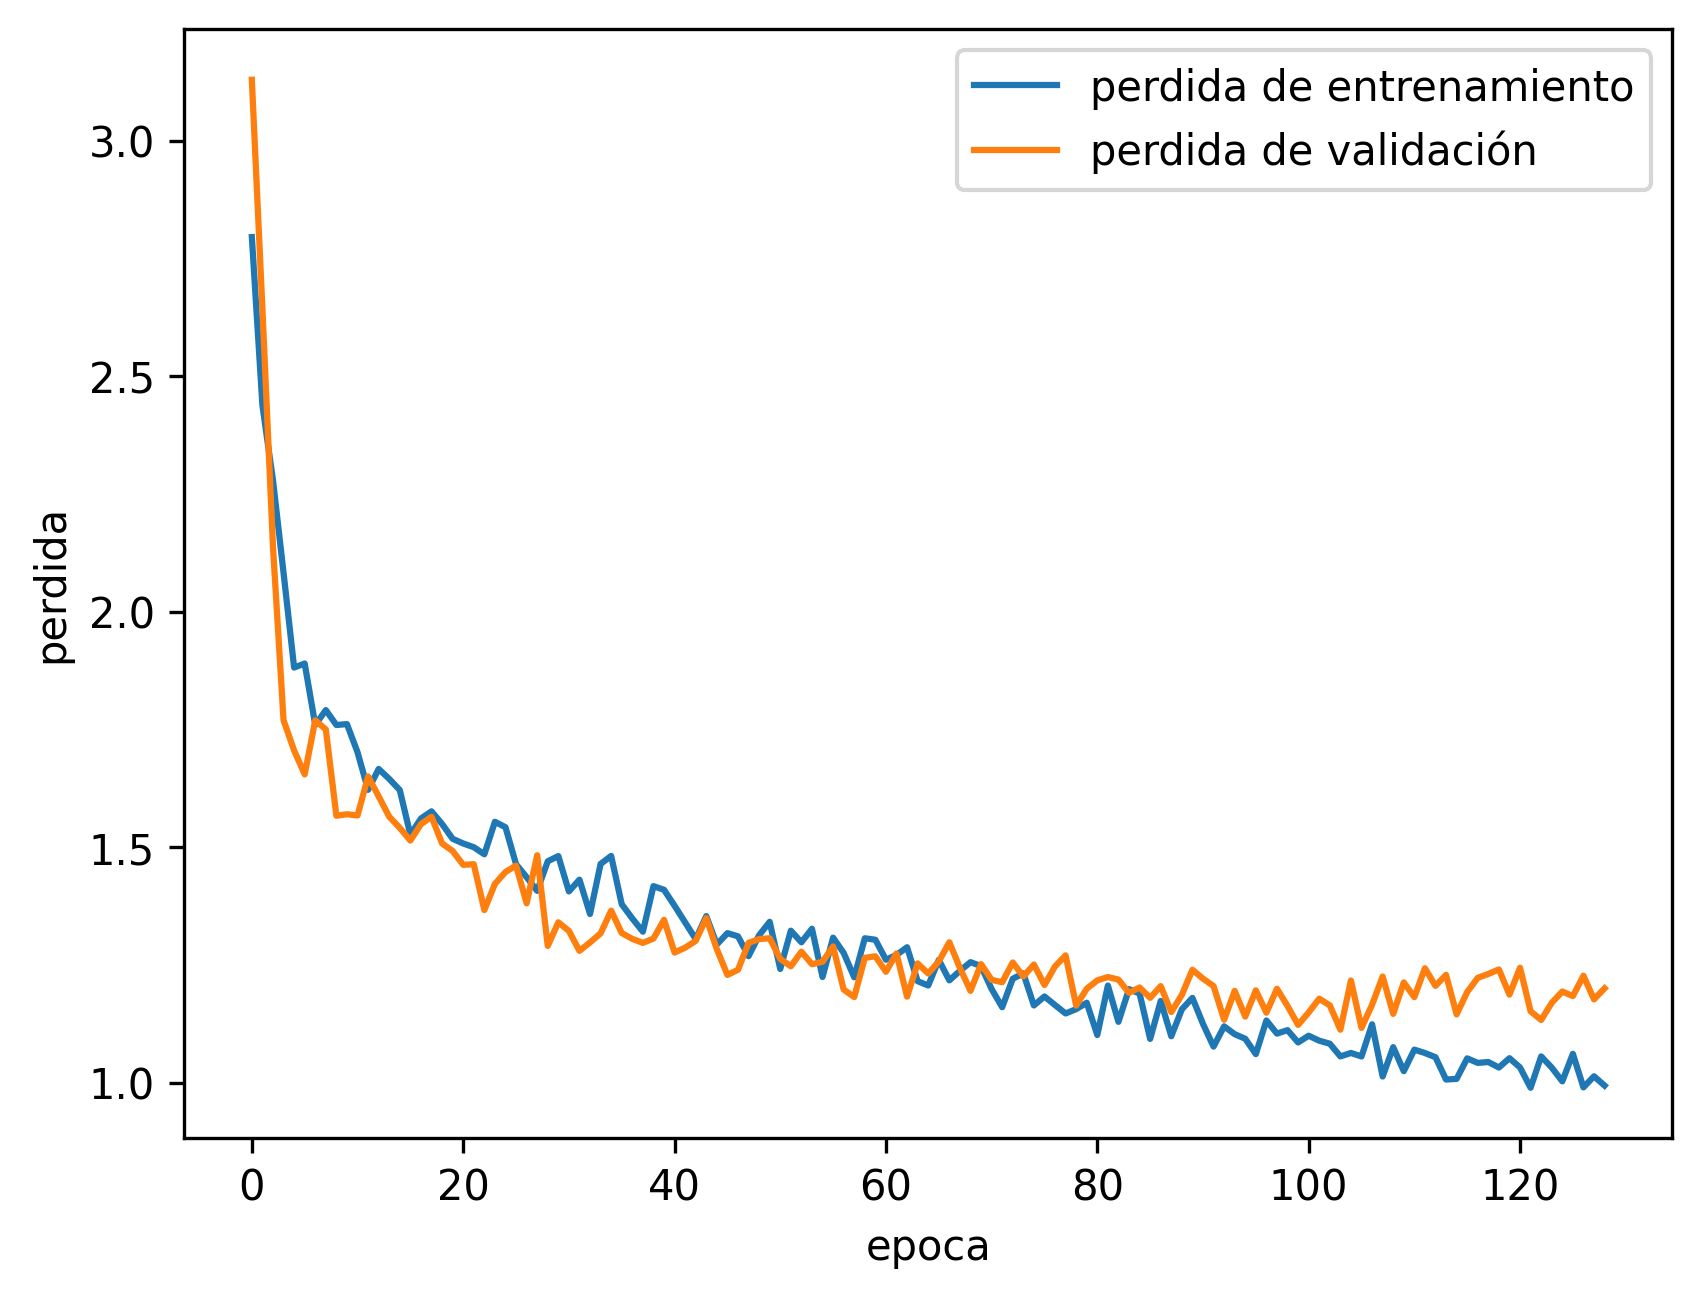

Best validation loss: 1.1127873750833364
epoch for best validation loss: 103


In [24]:
# best quality for plots
plt.rcParams['figure.dpi'] = 300

losses = pd.read_csv('losses_960.csv')
train_losses = losses['train_loss']
val_losses = losses['val_loss']

plt.plot(train_losses, label='perdida de entrenamiento')
plt.plot(val_losses, label='perdida de validación')
# set x-axis label
plt.xlabel('epoca')
# set y-axis label
plt.ylabel('perdida')
plt.legend()
plt.show()

print("Best validation loss:", best_val_loss)
print("epoch for best validation loss:", np.argmin(val_losses))

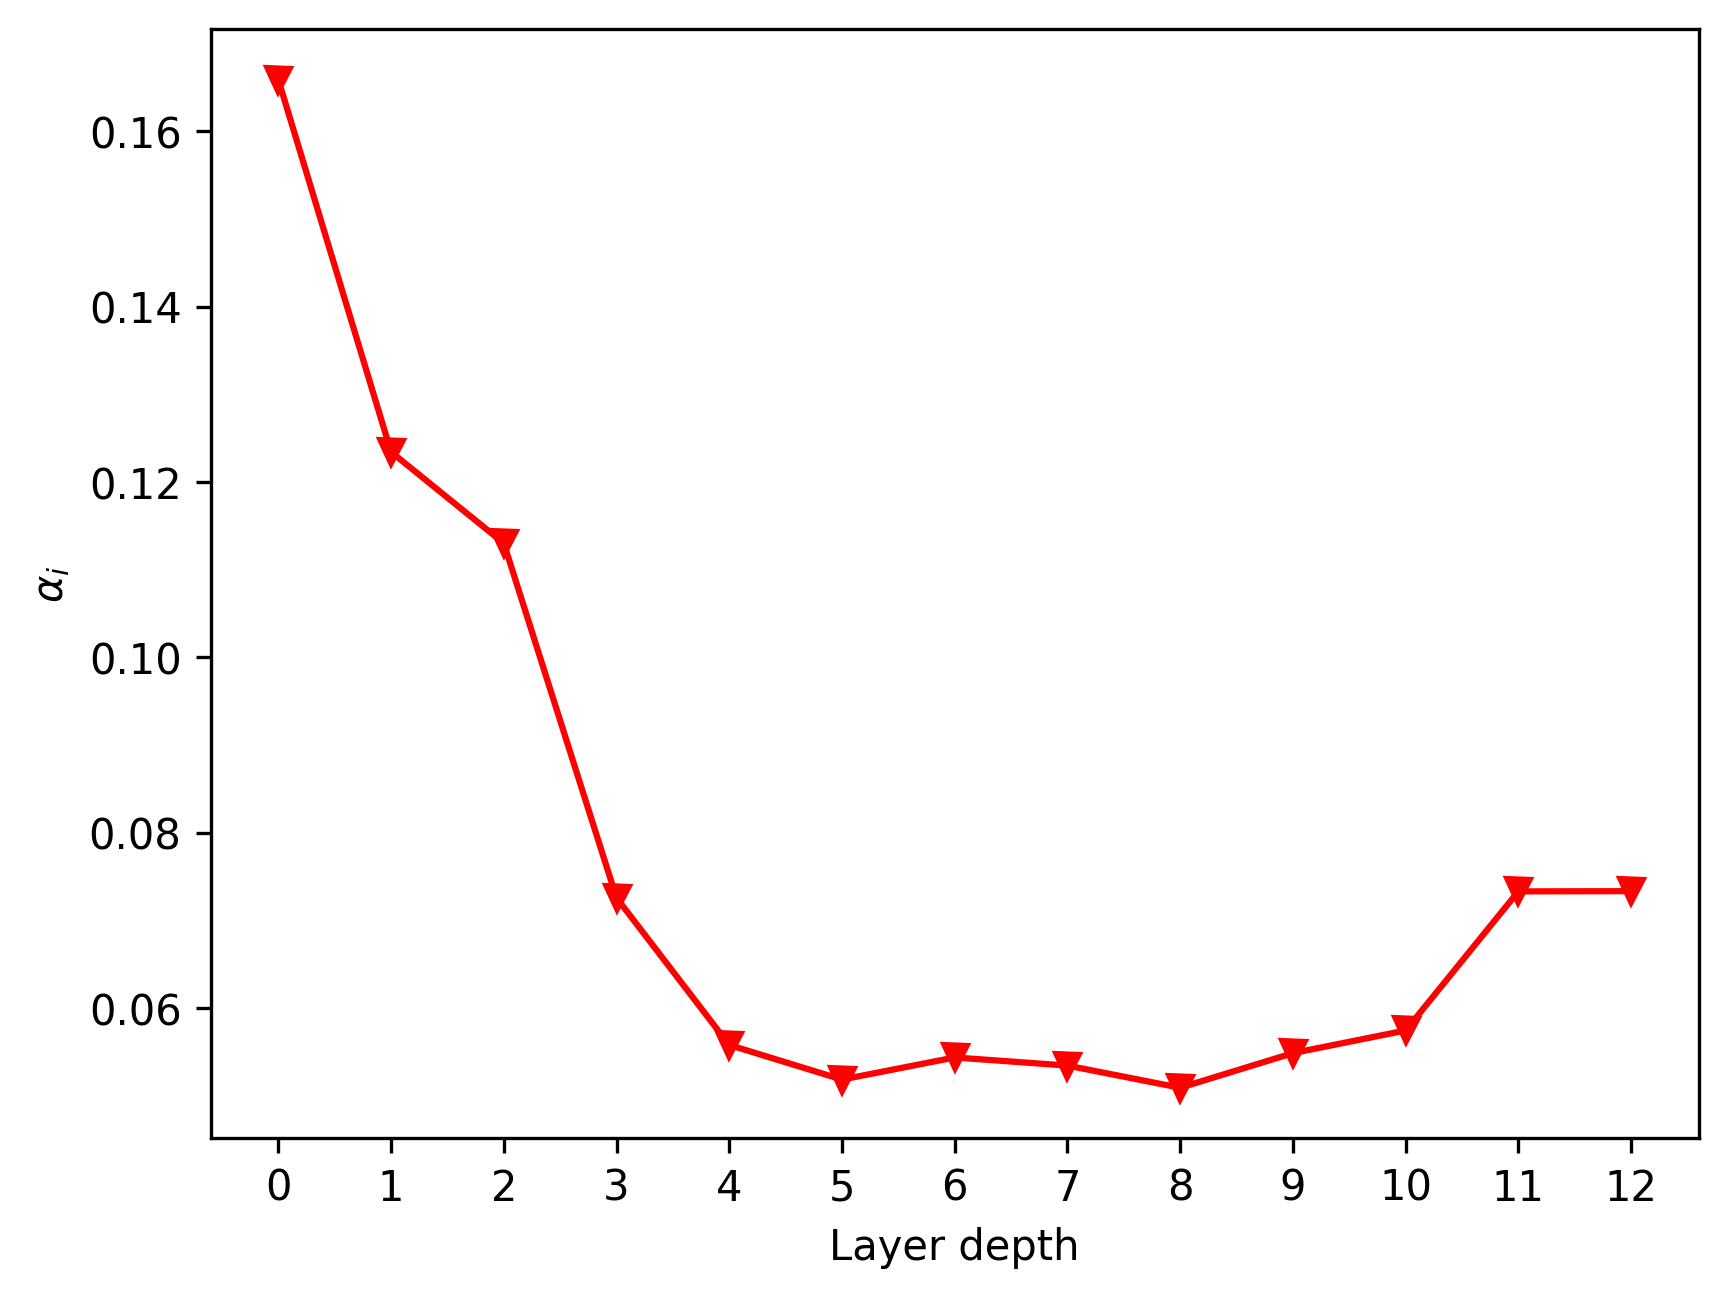

In [26]:
# plot the torch.nn.functional.softmax(dense_mos.weighted_average.weights, dim=0)
# aka the layer number and its importance
softmax_weights = torch.nn.functional.softmax(dense_mos.weighted_average.weights, dim=0).detach().cpu().numpy()
#save the weights to a csv
weights = pd.DataFrame({'softmax_weights': softmax_weights})
weights.to_csv('softmax_weights_960_2.csv', index=False)

plt.plot(softmax_weights, marker='v', linestyle='-', color='red', alpha=1, label='Softmax Weights')
plt.xlabel('Layer depth')
plt.xticks(range(13))
# y label is alpha character, the greek letter, with a subindice 
plt.ylabel(r'$\alpha_i$')
plt.show()

# Evaluation and Testing

In [27]:
# Create the testing DataLoader
test_csv_path = "/home/aleph/tesis/classifier/test_shuffled.csv"
test_dataset = MOSDataset(test_csv_path, split='test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load the best model
best_model_path = "/home/aleph/tesis/classifier/DenseMOS_tests/best_model_960.pth"
dense_mos = DenseMOS(input_dim=768, hidden_dim=128, dropout_prob=0.6, num_layers=13)  # Ensure correct model initialization
dense_mos.to(device)  # Move the model to the device
dense_mos.load_state_dict(torch.load(best_model_path))  # Load the saved models
dense_mos.eval()  # Set model to evaluation mode

# Evaluate the model on the test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # DataLoader for testing
test_loss = 0.0
outputs_list = []
targets_list = []
with torch.no_grad():  # No gradients needed during evaluation
    for inputs, targets in test_loader:
        inputs = inputs.to(device)  # Move inputs to the GPU
        targets = targets.to(device)  # Move targets to the GPU
        outputs = dense_mos(inputs)  # Forward pass
        outputs_list.append(outputs)
        targets_list.append(targets)
        loss = loss_fn(outputs, targets)  # Calculate loss
        test_loss += loss.item()  # Accumulate the loss

# Average test loss over all batches
avg_test_loss = test_loss / len(test_loader)
print("Test Loss:", avg_test_loss)  # Evaluate the model's performance on the test set

# Convert targets and outputs to NumPy arrays
targets = np.squeeze(torch.cat(targets_list).cpu().numpy())
outputs = np.squeeze(torch.cat(outputs_list).cpu().numpy())


Test Loss: 1.0886202660890727


In [28]:
# calculate pearson's correlation coefficient and targets_array, compute mae, mse, rmse and r2
# between the predicted MOS scores and the ground truth MOS scores, aka the targets and outputs

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

# Calculate Pearson's correlation coefficient
pearson_corr = pearsonr(targets, outputs)
print("Pearson's Correlation Coefficient:", pearson_corr[0])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(targets, outputs)
print("Mean Absolute Error (MAE):", mae)
rmse = mean_squared_error(targets, outputs, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)
r2 = r2_score(targets, outputs)
print("R^2 Score:", r2)


Pearson's Correlation Coefficient: 0.5975191260352075
Mean Absolute Error (MAE): 0.8024252
Root Mean Squared Error (RMSE): 1.0697892
R^2 Score: 0.3039193284927606


/home/aleph/tesis/.env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [29]:
# print target and outputs side by side
# for i in range(200):
#     print(f"Target: {targets[i]:.2f}, Output: {outputs[i]:.2f}")
# print outputs that are above 5
for i in range(len(outputs)):
    if outputs[i] > 5:
        print(f"Target: {targets[i]:.2f}, Output: {outputs[i]:.2f}")
        # print stimuli name
        print(test_dataset.data.iloc[i]['stimuli'])

In [30]:
# save the targets and outputs to a csv
targets_outputs = pd.DataFrame({'target': targets, 'output': outputs})
targets_outputs.to_csv('targets_outputs_960.csv', index=False)

In [37]:
# combine targets and outputs into a dataframe
results = pd.read_csv("targets_outputs_960.csv")
# clip values between 1 and 5
results['output'] = results['output'].clip(1, 5)
results
# results

,target,output
0,2.0,1.748155
1,2.0,2.092823
2,3.0,1.883329
3,1.0,2.400019
4,3.0,2.449943
...,...,...
387,1.0,1.000000
388,4.0,4.659750
389,3.0,2.519336
390,3.0,2.369658


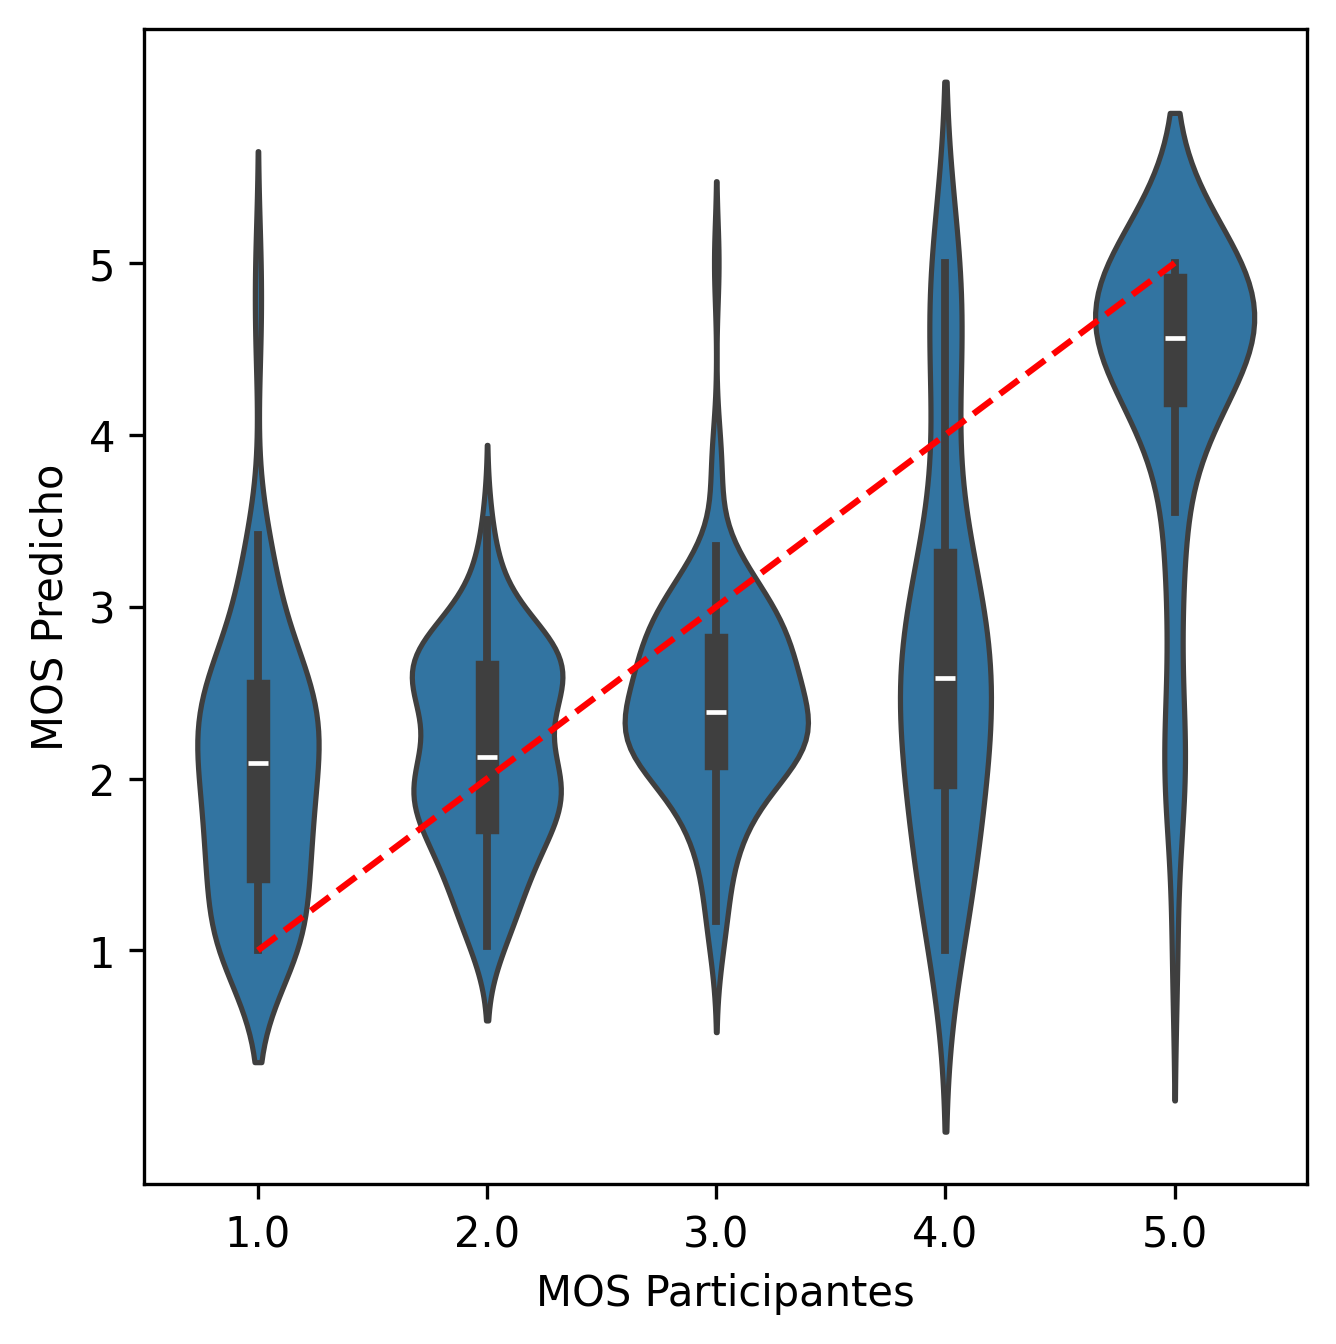

In [38]:
# violin plot of the targets and outputs
import seaborn as sns
import matplotlib.pyplot as plt


# now, lets plot the same data but with seaborn using a violin plot
fig, ax = plt.subplots(figsize=(5, 5))
sns.violinplot(x=results["target"], y=results["output"])
# ax.set_title('Wav2vec2-FT')
ax.set_xlabel('MOS Participantes')
ax.set_ylabel('MOS Predicho')
ax.plot([0, 4], [1, 5], 'r--')
# y labels
plt.yticks([1,2,3,4,5])
plt.show()
